<a href="https://colab.research.google.com/github/FF12RR77/Applied-Data-Science-Capstone/blob/master/Capstone_Project_The_Battle_of_Neighborhoods_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capstone: Find the best neighborhood in Toronto to open a Farmers Market

Load all the Data from all the various sources

In [65]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter('ignore')

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from bs4 import BeautifulSoup
import requests
import pandas as pd

print('Libraries imported.')

Libraries imported.


####Scraping the Wikipedia page for the table of postal codes of Canada and Data preprocessing and cleaning

In [66]:
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)


# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
postaltable=soup.find('table',{'class':"wikitable"})


df=pd.read_html(str(postaltable))
# convert list to dataframe
df=pd.DataFrame(df[0])
print(df.head())


# Dropping the rows where Borough is 'Not assigned'
df_new = df[df.Borough != 'Not assigned']

# Combining the neighbourhoods with same Postalcode

df2= df_new.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df2.head()

# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
df2.Neighbourhood =  np.where(df2.Neighbourhood == "Not assigned",df2.Borough,df2.Neighbourhood)
df2

df2.shape

200
  Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront


(103, 3)

#### Make sure that you have created a Foursquare developer account and have your credentials handy

In [ ]:
CLIENT_ID = 'KU-KU' # your Foursquare ID
CLIENT_SECRET = 'KU-KU' # your Foursquare Secret
VERSION = '20201128'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

####In order to define an instance of the geocoder, we need to define a user_agent.We will name our agent ca_explorer, as shown below

In [68]:
address = 'Toronto, TO'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.65238435, -79.38356765.


####Importing the csv file conatining the latitudes and longitudes for various neighbourhoods in Canada

In [69]:
df_geo = pd.read_csv('https://cocl.us/Geospatial_data')
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [70]:
df3 = pd.merge(df2, df_geo, on = 'Postal Code')
df3.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [71]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df3['Borough'].unique()),
        df3.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [72]:
Toronto_data = df3[df3['Borough'] == 'Toronto'].reset_index(drop=True)
Toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude


In [73]:
#We use  only "Borough" which contains the word:  Toronto 
df4=df3[df3['Borough'].str.contains('Toronto')]
Toronto_data=df4.reset_index(drop=True)
Toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


###Visualizing all the Neighbourhoods of the above data frame using Folium

In [74]:
# create map of New York using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, borough, neighbourhood in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Borough'], Toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

####Let's create the GET request URL and name our URL. Then we create a function that extracts the category of the venue. Finally, we are ready to clean the json and structure it into a pandas dataframe.

In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

####Get all the Venues in Toronto

In [76]:
Toronto_data_venues = getNearbyVenues(names=Toronto_data['Neighbourhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

In [77]:
print(Toronto_data_venues.shape)
Toronto_data_venues.head()

(854, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


In [78]:
#Number of venues per neighborhood
Toronto_data_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,30,30,30,30,30,30
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",14,14,14,14,14,14
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,30,30,30,30,30,30
Christie,15,15,15,15,15,15
Church and Wellesley,30,30,30,30,30,30
"Commerce Court, Victoria Hotel",30,30,30,30,30,30
Davisville,30,30,30,30,30,30


In [79]:
#Number of unique venue categories
print('There are {} uniques categories.'.format(len(Toronto_data_venues['Venue Category'].unique())))

There are 197 uniques categories.


In [80]:
#print out the list of categories
Toronto_data_venues['Venue Category'].unique()

array(['Trail', 'Health Food Store', 'Pub', 'Neighborhood',
       'Cosmetics Shop', 'Greek Restaurant', 'Italian Restaurant',
       'Ice Cream Shop', 'Yoga Studio', 'Brewery',
       'Fruit & Vegetable Store', 'Restaurant', 'Pizza Place',
       'Juice Bar', 'Bookstore', 'Furniture / Home Store', 'Dessert Shop',
       'Bubble Tea Shop', 'Spa', 'Grocery Store', 'Coffee Shop',
       'Tibetan Restaurant', 'Bakery', 'Indian Restaurant', 'Gym',
       'Fish & Chips Shop', 'Fast Food Restaurant', 'Sushi Restaurant',
       'Park', 'Liquor Store', 'Pet Store', 'Steakhouse', 'Burrito Place',
       'Movie Theater', 'Sandwich Place', 'Board Shop',
       'Food & Drink Shop', 'Fish Market', 'Seafood Restaurant',
       'Gay Bar', 'Café', 'American Restaurant', 'Cheese Shop',
       'Comfort Food Restaurant', 'Middle Eastern Restaurant',
       'Stationery Store', 'Thai Restaurant', 'Coworking Space',
       'Gastropub', 'Clothing Store', 'Gym / Fitness Center', 'Bar',
       'Business Servic

In [82]:
#check if there any Farmers Market in Venues
"Farmers Market" in Toronto_data_venues['Venue Category'].unique()

True

###OneHot encode and count Farmers Markets

In [83]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_data_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_data_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]
print(Toronto_onehot.shape)

Toronto_onehot.columns

(854, 197)


Index(['Yoga Studio', 'Airport', 'Airport Food Court', 'Airport Gate',
       'Airport Lounge', 'Airport Service', 'Airport Terminal',
       'American Restaurant', 'Antique Shop', 'Aquarium',
       ...
       'Theater', 'Theme Restaurant', 'Tibetan Restaurant', 'Toy / Game Store',
       'Trail', 'Train Station', 'Vegetarian / Vegan Restaurant',
       'Video Game Store', 'Vietnamese Restaurant', 'Wine Bar'],
      dtype='object', length=197)

In [20]:
Toronto_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts School,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Spa,Speakeasy,Sporting Goods Shop,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0

####Analyze each neighbourhood

In [22]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
print(Toronto_grouped.shape)
Toronto_grouped

(39, 197)


,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts School,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Organic Grocery,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Spa,Speakeasy,Sporting Goods Shop,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,0.066667,0.000000,0.000000,0.033333,0.000000,0.0000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.00

# Let's plot Neighborhoods with amount of Farmers Markets

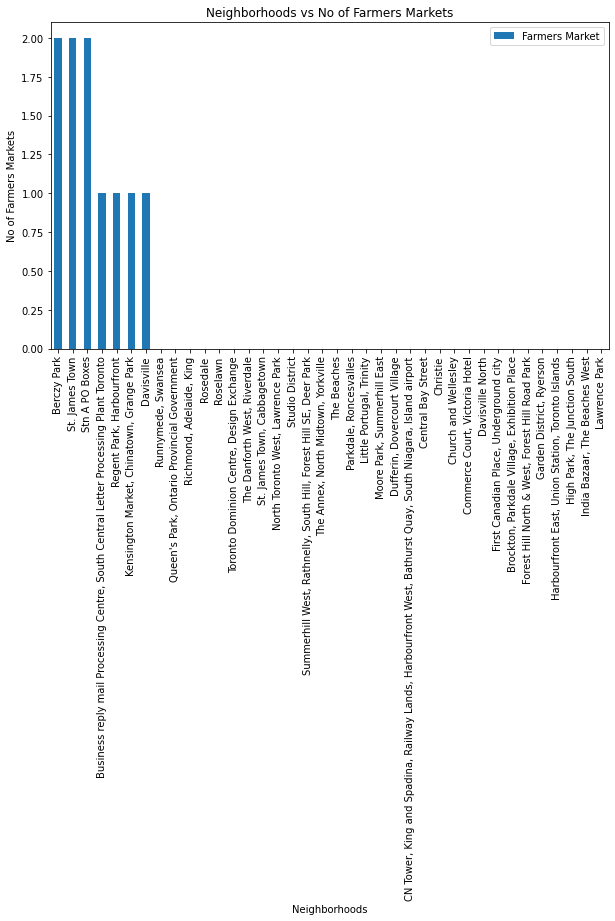

In [61]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

graph = pd.DataFrame(Toronto_onehot.groupby('Neighborhood')['Farmers Market'].sum())
graph = graph.sort_values(by ='Farmers Market', ascending=False)
graph.iloc[:38].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Farmers Markets")
plt.title("Neighborhoods vs No of Farmers Markets")
plt.show()

#### How much neighborhoods have one or more Farmers Markets


In [64]:
print("Only",len(Toronto_grouped[Toronto_grouped["Farmers Market"] > 0]),"neighborhoods have one or more Farmers Markets")

Only 7 neighborhoods have one or more Farmers Markets


In [27]:
New_F_Market = Toronto_grouped[["Neighborhood","Farmers Market"]]
New_F_Market

,Neighborhood,Farmers Market
0,Berczy Park,0.066667
1,"Brockton, Parkdale Village, Exhibition Place",0.000000
2,"Business reply mail Processing Centre, South C...",0.071429
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.000000
5,Christie,0.000000
6,Church and Wellesley,0.000000
7,"Commerce Court, Victoria Hotel",0.000000
8,Davisville,0.033333
9,Davisville North,0.000000


###Add the K-Means Labels

In [28]:
kclusters = 2

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:38]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [29]:
# create a new dataframe that includes the cluster
Toronto_merged = New_F_Market.copy()

# add clustering labels
Toronto_merged["Cluster Labels"] = kmeans.labels_

In [30]:
Toronto_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
Toronto_merged

,Neighborhood,Farmers Market,Cluster Labels
0,Berczy Park,0.066667,0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0
2,"Business reply mail Processing Centre, South C...",0.071429,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.000000,0
5,Christie,0.000000,0
6,Church and Wellesley,0.000000,0
7,"Commerce Court, Victoria Hotel",0.000000,0
8,Davisville,0.033333,0
9,Davisville North,0.000000,0


In [31]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(Toronto_data_venues.set_index("Neighborhood"), on="Neighborhood")

print(Toronto_merged.shape)
Toronto_merged.head()

(854, 9)


,Neighborhood,Farmers Market,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.066667,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.066667,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.066667,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.066667,0,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.066667,0,43.644771,-79.373306,Berczy Park,43.648048,-79.375172,Park


In [85]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Neighborhood Latitude'], Toronto_merged['Neighborhood Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
#Cluster 0
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0]


In [59]:
#Cluster 1
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1]

,Neighborhood,Farmers Market,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
20,"Moore Park, Summerhill East",0.0,1,43.689574,-79.38316,Reds,43.692816,-79.384504,Restaurant
20,"Moore Park, Summerhill East",0.0,1,43.689574,-79.38316,Moore Park Tennis Club,43.693289,-79.382900,Tennis Court


In [35]:
Toronto_merged['Cluster Labels'].value_counts()

0    852
1      2
Name: Cluster Labels, dtype: int64